<h1>Table of Contents</h1>
<ol>
    <li><a href="#introduction">Introduction</a></li>
    <li><a href="#setup">Setup</a>
        <ul>
            <li><a href="#colab">Running the notebook in Colab</a></li>
            <li><a href="#import-libraries">Import required libraries</a></li>
        </ul>
    </li>
    <li><a href="#data-access">Data access, download and pre-processing</a>
        <ul>
            <li><a href="#upload-laz">Option 1: Upload your own point cloud files</a></li>
            <li><a href="#upload-dem">Option 2: Upload your own DEMs</a></li>
            <li><a href="#download-laz">Option 3: Download point clouds using OpenTopography API</a></li>
            <li><a href="#upload-download-mix">Option 4: Upload one file and download another</a></li>
        </ul>
    </li>
    <li><a href="#visualization">Visualization and Derived Rasters</a>
        <ul>
            <li><a href="#plot-dems">Plot the DEMs</a></li>
            <li><a href="#hillshade">Hillshade</a></li>
            <li><a href="#slope">Slope</a></li>
            <li><a href="#aspect">Aspect</a></li>
            <li><a href="#roughness">Roughness</a></li>
        </ul>
    </li>
    <li><a href="#differencing">Differencing</a></li>
    <li><a href="#error-analysis">Error Analysis</a>
        <ul>
            <li><a href="#define-stable-areas">Define stable areas</a></li>
            <li><a href="#descriptive-stats">Descriptive Statistics</a></li>
            <li><a href="#estimate-error">Estimate systematic error</a></li>
        </ul>
    </li>
</ol>
                                               

<h1><a id="introduction"></a>1. Introduction</h1>

Vertical topographic differencing is a powerful technique for quantifying landscape change by comparing digital elevation models (DEMs) from different time periods. This notebook provides a comprehensive workflow for performing this analysis, with a strong emphasis on robustly quantifying the associated uncertainty. The methods implemented here are designed to identify and model various error components, including systematic bias and spatially correlated errors, which can otherwise obscure real topographic signals. The core of this workflow is a geostatistical approach that uses variogram analysis to characterize the spatial structure of error, allowing for a more nuanced and accurate assessment of topographic change than traditional methods.

The primary goal of this notebook is to provide a step-by-step guide for users to apply these methods to their own data. The analysis is broken down into several key steps:

* **Data Loading:** Importing the necessary point clouds, DEMs and metadata.
* **Topographic Differencing:** Calculating the difference between the DEMs.
* **Stable/Unstable Area Identification:** Delineating areas that are assumed to be unchanged between surveys to assess the survey-to-survey error.
* **Uncertainty Analysis:** Using variography to model the spatial structure of the error and generate mean uncertainty estimates.

<h2><a id="setup"></a>2. Setup</h2>

<h3><a id="colab"></a>Running the notebook in Colab</h3>

For ease-of-use, it is suggested to launch and execute these notebooks on <a href="https://colab.research.google.com/">Google Colaboratory</a> (Colab, for short), Google's Cloud Platform. Dependencies will be installed on a virtual machine on Google's cloud servers and the code will be executed directly in your browser. A major benefit of this is that you will have direct access to Google's high-end CPU/GPUs and will not have to install any dependencies locally. All deliverables will be saved to your personal Google Drive. To experiment and run one of the below Jupyter Notebooks on Google Colab click the "Open in Colab" badge below.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Cassandra-Brigham/topographic-difference-uncertainty/blob/main/my_implementation.ipynb)

In [1]:
# Colab setup check
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print(f"Running in Colab with Python {sys.version}")
else:
    print("Not running in Colab")


Not running in Colab; skipping Conda bootstrap.


In [ ]:
import os, sys, pathlib

# --- Colab guard ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # 1) Mount Drive (idempotent)
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)

    # 2) Install condacolab for PDAL (requires kernel restart)
    # Check if condacolab is already set up
    try:
        import condacolab
        condacolab.check()
        print("✓ Condacolab already installed")
        CONDACOLAB_READY = True
    except:
        print("Installing condacolab (kernel will restart)...")
        !pip install -q condacolab
        import condacolab
        condacolab.install()  # This restarts the kernel
        CONDACOLAB_READY = False
else:
    print("Not running in Colab; skipping condacolab setup.")
    CONDACOLAB_READY = True

In [ ]:
import os, sys, pathlib

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Verify condacolab and install PDAL
    import condacolab
    condacolab.check()
    
    # Remove conflicting Python pin and install PDAL
    !rm -f /usr/local/conda-meta/pinned
    !mamba install -y -c conda-forge pdal python-pdal
    
    # Set PROJ environment
    os.environ['PROJ_LIB'] = '/usr/local/share/proj/'
    
    # Clone/update repository
    REPO_URL = "https://github.com/Cassandra-Brigham/topographic-difference-uncertainty"
    REPO_DIR = "/content/topographic-difference-uncertainty"
    if not pathlib.Path(REPO_DIR).exists():
        !git clone "$REPO_URL" "$REPO_DIR"
    else:
        !git -C "$REPO_DIR" fetch --all
        !git -C "$REPO_DIR" reset --hard origin/HEAD
    
    # Add repository to Python path
    sys.path.insert(0, REPO_DIR)
    
    # Change to repo directory
    %cd "$REPO_DIR"
    
    # Install other Python packages
    print("\nInstalling additional Python packages...")
    !{sys.executable} -m pip install -q rasterio pyproj shapely geopandas small-gicp colormaps rioxarray
    
    # Install remaining requirements (excluding already installed)
    !grep -vE '^[[:space:]]*(#|osgeo|gdal|pdal|small-gicp|rasterio|pyproj|shapely|geopandas)[[:space:]]*$' requirements.txt > /tmp/req-filtered.txt 2>/dev/null || true
    !grep -vE '^[[:space:]]*$' /tmp/req-filtered.txt > /tmp/req-clean.txt 2>/dev/null || true
    !{sys.executable} -m pip install -q -r /tmp/req-clean.txt 2>/dev/null || true
    
    # Verify PDAL via wrapper
    from pdal_wrapper import pdal, get_pdal_status
    status = get_pdal_status()
    print(f"\n✓ Environment ready!")
    print(f"  PDAL version: {status['version']}")
    print(f"  PDAL mode: {status['mode']}")
else:
    # Local development
    current_dir = pathlib.Path.cwd()
    if str(current_dir) not in sys.path:
        sys.path.insert(0, str(current_dir))
    print("Not running in Colab; skipping environment setup.")
    
    # Verify local pdal
    try:
        from pdal_wrapper import pdal, get_pdal_status
        status = get_pdal_status()
        print(f"PDAL version: {status['version']} (mode: {status['mode']})")
    except Exception as e:
        print(f"Warning: PDAL not available: {e}")

In [3]:
# Install visualization libraries
%pip install -q comm ipywidgets
%pip install -q ipyleaflet



# Fix pyproj PROJ path (Colab-specific, may need adjustment based on conda installation)
import os
import sys

# Set PROJ_LIB if needed (conda usually handles this automatically)
if IN_COLAB and not os.environ.get("PROJ_LIB"):
    from google.colab import output
    output.enable_custom_widget_manager()
    # Try common conda locations first
    possible_proj_paths = [
        "/opt/conda/share/proj",
        "/usr/share/proj", 
        "/usr/local/share/proj"
    ]
    for proj_path in possible_proj_paths:
        if os.path.isdir(proj_path):
            os.environ["PROJ_LIB"] = proj_path
            break

# ============================================================================
# API Key Setup - Hybrid approach for maximum compatibility
# ============================================================================
# Try to get OPENTOPO_API_KEY from multiple sources:
# 1. Colab Secrets (most secure for Colab users)
# 2. Environment variable (works locally and in Colab)
# 3. Manual setting (fallback)

api_key = None

if IN_COLAB:
    # Try Colab secrets first (recommended for Colab users)
    try:
        from google.colab import userdata
        api_key = userdata.get('OPENTOPOGRAPHY_API_KEY')
        print("✓ Using OPENTOPOGRAPHY_API_KEY from Colab secrets")
    except Exception:
        # Fall back to environment variable
        api_key = os.getenv('OPENTOPOGRAPHY_API_KEY')
        if api_key:
            print("✓ Using OPENTOPOGRAPHY_API_KEY from environment variable")
        else:
            print("⚠️  OPENTOPOGRAPHY_API_KEY not found!")
            print("   Option 1 (Recommended): Add to Colab secrets via the 🔑 icon in left sidebar")
            print("   Option 2: Run this in a cell: os.environ['OPENTOPO_API_KEY'] = 'your_key_here'")
            print("   Get your key at: https://portal.opentopography.org/requestService")
else:
    # Local environment - use environment variable
    api_key = os.getenv('OPENTOPOGRAPHY_API_KEY')
    if api_key:
        print("✓ Using OPENTOPOGRAPHY_API_KEY from environment variable")
    else:
        print("⚠️  OPENTOPOGRAPHY_API_KEY not found in environment variables")
        print("   Set it in your shell before running Jupyter, or run:")
        print("   os.environ['OPENTOPOGRAPHY_API_KEY'] = 'your_key_here'")
# Set the environment variable if we found a key
if api_key:
    os.environ['OPENTOPOGRAPHY_API_KEY'] = api_key

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✓ Using OPENTOPOGRAPHY_API_KEY from environment variable


In [4]:
# ============================================================================
# Data Path Configuration
# ============================================================================
# Configure base paths for data files based on environment (Colab vs Local)
#
# INSTRUCTIONS FOR USERS:
# - Colab users: Update COLAB_DATA_DIR to point to your Google Drive data folder
# - Local users: Update LOCAL_DATA_DIR to point to your local data folder
# ============================================================================

import os
from pathlib import Path

if IN_COLAB:
    # Google Drive data directory (update this to your actual data location)
    # Example: "/content/drive/MyDrive/Research/topographic-data"
    COLAB_DATA_DIR = "/content/drive/MyDrive/topographic-differencing-data"
    BASE_DATA_DIR = Path(COLAB_DATA_DIR)
    
    print(f"✓ Using Colab data directory: {BASE_DATA_DIR}")
    print(f"  Note: Update COLAB_DATA_DIR in this cell to match your Google Drive structure")
else:
    # Local data directory (update this to your local path)
    LOCAL_DATA_DIR = "/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data"
    BASE_DATA_DIR = Path(LOCAL_DATA_DIR)
    
    print(f"✓ Using local data directory: {BASE_DATA_DIR}")

# Create base directory if it doesn't exist
BASE_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Helper function to resolve data paths
def get_data_path(*path_parts):
    """Resolve a data path relative to BASE_DATA_DIR"""
    return str(BASE_DATA_DIR / Path(*path_parts))

✓ Using local data directory: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data


<h3><a id="import-libraries"></a>Import required libraries</h3>

This cell imports the necessary Python libraries for data handling and analysis, including custom functions from the provided scripts for differencing, variography, and stable area analysis.

In [ ]:
# Ensure repo is in Python path (needed after runtime restart)
import sys
if '/content/topographic-difference-uncertainty' not in sys.path:
    sys.path.insert(0, '/content/topographic-difference-uncertainty')

import colormaps as cmaps
import os
import numpy as np
import importlib
import rasterio


from crs_utils import (crs_to_projjson,
                                               _ensure_crs_obj,
                                               crs_to_wkt2_2019,
                                               wrap_coordinate_metadata_wkt,
                                               crs_to_projjson,
                                               make_coordinate_metadata_projjson,
                                               transformer_with_epoch)
from geoid_utils import (_iter_text_fields,
                                 _search_patterns,
                                 _from_json_vertical,
                                 parse_geoid_info,
                                 list_proj_geoid_grids,
                                 _norm,
                                 _matches_alias,
                                 select_geoid_grid,
                                 ensure_proj_grid,
                                 ensure_proj_grids_for_region,
                                 get_all_proj_data_dirs)
from time_utils import (_gps_leap_seconds,
                                _datetime_to_decimal_year,
                                gps_seconds_to_decimal_year_utc,
                                _guess_in_time_from_stats,
                                )


from crs_history import CRSHistory

from pointcloud import PointCloud

from raster import Raster

from pointcloudpair import PointCloudPair

from rasterpair import RasterPair

from alignment import (RegistrationMethod,
                            DownsamplingMethod,
                            RegistrationConfig,
                            PointCloudProcessor,
                            RegistrationResult,
                            LandscapeAligner,
                            PointCloudPairAligner,
                            quick_align,
                            robust_align,)

from pipeline_builder import CRSState, build_complete_pipeline

from velocity_model_registry import (
    VelocityModelInfo,
    load_registry,
    select_velocity_model,
    find_model_file,
#    registry_select_model,
)   

from deformation_utils import (select_velocity_model)

from alignment import (RegistrationMethod,
                            DownsamplingMethod,
                            RegistrationConfig,
                            PointCloudProcessor,
                            RegistrationResult,
                            LandscapeAligner,
                            PointCloudPairAligner,
                            quick_align,
                            robust_align,)

#import adv_diff.differencing as differencing
from  uncertainty import RegionalUncertaintyEstimator
from variogram import (
    RasterDataHandler,
    StatisticalAnalysis,
    VariogramAnalysis,
)
import  data_access as data_access
from data_access import (DataAccess,
                                  OpenTopographyQuery,
                                  GetDEMs,
                                  )
from stable_area_analysis import (
                                TopoMapInteractor,
                                descriptive_stats,
                                StableAreaRasterizer,
                                StableAreaAnalyzer,
                                )#

                               


SEED = 42

# ============================================================
# Ensure PROJ geoid grids are available (works in Colab & locally)
# ============================================================
# This automatically downloads missing grids to all PROJ data directories,
# ensuring compatibility with pyproj, PDAL, and GDAL.

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print("Setting up PROJ geoid grids for Colab...")
    print(f"PROJ data directories: {get_all_proj_data_dirs()}")
    
    # Ensure common US NOAA geoid grids are available
    # This downloads GEOID12B, GEOID18, GEOID09, etc.
    ensure_proj_grids_for_region('us_noaa', verbose=True)
    
    print("\n✓ PROJ geoid grids ready")

<h1><a id="data-access"></a>Data access, download and pre-processing</h1>

This section outlines four options for loading your compare (older) and reference (newer) topographic datasets. [cite_start]The pre-processing steps ensure that both datasets are aligned to a common coordinate reference system (CRS), grid, and vertical datum, which is essential for accurate differencing[cite: 66, 109].

<h2><a id="upload-laz"></a>Option 1: Upload your own point cloud files</h2>

Use this option if you have local `.las` or `.laz` point cloud files. The code will generate Digital Terrain Models (DTMs) and Digital Surface Models (DSMs) from your data and then align them.

In [6]:
# Define point cloud file paths
# Update the paths below to match your data structure within BASE_DATA_DIR
compare_pc_path = get_data_path("CA/area4/compare.laz")
reference_pc_path = get_data_path("CA/area4/reference.laz")

In [7]:
# Complete these fields if known, comment out if unknown

COMPLETE_CRS_COMPARE = "4979" # e.g., "EPSG:3136+EPSG:5703"
HORIZ_CRS_COMPARE = None # e.g., "32611" 
VERT_CRS_COMPARE = None # e.g., "5703" 
GEOID_COMPARE = None # e.g., "geoid12b"
EPOCH_COMPARE = "05/18/2005 - 05/27/2005"

COMPLETE_CRS_REFERENCE = None # e.g., "EPSG:3136+EPSG:5703"
HORIZ_CRS_REFERENCE = None # e.g., "32611" 
VERT_CRS_REFERENCE = "5703" 
GEOID_REFERENCE = "geoid12b"
EPOCH_REFERENCE = "05/27/2018 - 07/22/2018"

<h3><a id="extract_metadata"></a>Extract metadata from point cloud file</h3>


- Input format: use a point cloud in .las or .laz format.
- The path to the compare point cloud is already set in compare_pc_path.
- In the next cells, a PointCloud object (pc1) is created from compare_pc_path, its metadata is read from the file header/VLRs, and then printed for review.
- This step only inspects metadata (CRS, vertical datum/geoid, epoch, units, scales/offsets, bounds, classifications, returns, GPS time type); it does not modify the data.
- If key fields are missing or incorrect (e.g., compound CRS, horizontal/vertical CRS, geoid model, epoch), the following sections demonstrate how to update them using add_metadata before creating DEMs or performing transformations.

In [8]:
# Create PointCloud object and read in metadata
pc1 = PointCloud(compare_pc_path)
pc1.from_file()

In [9]:
pc1.print_metadata()

-----------
----CRS----
-----------
Original compound CRS: 
      PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]
Original horizontal CRS: 
      PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Tr

<h3><a id="update_metadata"></a>Update point cloud metadata</h3>



Sometimes the file will lack important metadata or the metadata will be parsed incorrectly. To remedy this, we can manually update the point cloud metadata if we know more information.


<h4><a id="update_compound"></a>Update compound Coordinate Reference System</h4>

In [10]:
# Update compound CRS, using either a PROJ string, a WKT string, or an EPSG code.
# Skip this step if you are sure the compound CRS is correct

# If compound CRS is wrong or missing, can update metadata manually
  
if COMPLETE_CRS_COMPARE:
    pc1.add_metadata(compound_CRS=COMPLETE_CRS_COMPARE)
else:
    pass
print(f"Original compound CRS: {pc1.original_compound_crs}")  
print(f"Updated compound CRS: {pc1.current_compound_crs}")

Original compound CRS: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]
Updated compound CRS: GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodeti

<h4><a id="update_horiz"></a>Update horizontal Coordinate Reference System</h4>

In [11]:
# Update horizontal CRS, using either a PROJ string, a WKT string, or an EPSG code.
# Skip this step if you are sure the horizontal CRS is correct.

if HORIZ_CRS_COMPARE:
    pc1.add_metadata(horizontal_CRS=HORIZ_CRS_COMPARE)
else:
    pass

print ("Original horizontal CRS:", pc1.original_horizontal_crs)
print("Original compound CRS:", pc1.original_compound_crs)
print("")
print(f"Updated horizontal CRS: {pc1.current_horizontal_crs}")
print(f"Updated compound CRS : {pc1.current_compound_crs}")

Original horizontal CRS: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]
Original compound CRS: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin"

<h4><a id="update_vertical"></a>Update vertical Coordinate Reference System</h4>

In [12]:
# Update vertical CRS, using either a PROJ string, a WKT string, or an EPSG code.

# Skip this step if you are sure the vertical CRS is correct.

if VERT_CRS_COMPARE:
    pc1.add_metadata(vertical_CRS=VERT_CRS_COMPARE)
else:
    pass

print ("Original vertical CRS:", pc1.original_vertical_crs)
print("Original compound CRS:", pc1.original_compound_crs)
print("")
print(f"Updated vertical CRS: {pc1.current_vertical_crs}")
print(f"Updated compound CRS : {pc1.current_compound_crs}")

Original vertical CRS: 
Original compound CRS: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]

Updated vertical CRS: VERTCRS["World Geodetic System 1984 ensemble Ellipsoidal Height",VDATUM["World Geodetic System 1984 ensemble"],CS[vertical,1],AXIS["ellipsoidal height (h)",up,LENGTHUNIT["metre",1]]]
Updated compound CRS : GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World

<h4><a id="update_geoid"></a>Update geoid</h4>

In [13]:
# If vertical coordinates are orthometric and geoid is wrong or missing, can update metadata manually
print(f"Original geoid model: \n {pc1.geoid_model}")
print(f"Original vertical CRS: \n {pc1.current_vertical_crs}")
print(f"Are the vertical coordinates orthometric?  \n {pc1.is_orthometric}")

Original geoid model: 
 None
Original vertical CRS: 
 VERTCRS["World Geodetic System 1984 ensemble Ellipsoidal Height",VDATUM["World Geodetic System 1984 ensemble"],CS[vertical,1],AXIS["ellipsoidal height (h)",up,LENGTHUNIT["metre",1]]]
Are the vertical coordinates orthometric?  
 False


In [14]:
# Update geoid, using either a PROJ string, a WKT string, or an EPSG code.
if GEOID_COMPARE:
    geoid_grid, _ =select_geoid_grid(GEOID_COMPARE,verbose=True)
    
    # If the automatic selection is not the desired grid, you can specify the index of your desired grid in the list of matches. Uncomment the lines below and set choice to the desired index.
    #geoid_grid_2, _ =select_geoid_grid(geoid, choice=1)
    #print(f"Select the second grid: {geoid_grid_2}")
    
    pc1.add_metadata(geoid_model=geoid_grid)
else:
    pass

print(f"Geoid model: {pc1.geoid_model}")
print(f"Vertical CRS:{pc1.current_vertical_crs}")
print(f"Are the vertical coordinates orthometric? {pc1.is_orthometric}")

Geoid model: None
Vertical CRS:VERTCRS["World Geodetic System 1984 ensemble Ellipsoidal Height",VDATUM["World Geodetic System 1984 ensemble"],CS[vertical,1],AXIS["ellipsoidal height (h)",up,LENGTHUNIT["metre",1]]]
Are the vertical coordinates orthometric? False



<h4><a id="update_epoch"></a>Update epoch</h4>

Accurate epoch metadata is critical when working with time-dependent coordinate reference systems and transformations.

- Many modern CRSs (e.g., ITRF, NAD83(2011), WGS84 realizations) are defined at a specific epoch and use velocities to propagate coordinates through time. Without the correct epoch, transformation pipelines cannot apply the right motion, leading to offsets.
- Horizontal positions can drift several centimeters per year due to tectonic motion; over a decade this can reach decimeter-level errors. Vertical biases can be similar or larger in areas with subsidence or uplift.
- When aligning point clouds to reference datasets collected at different times, mismatched epochs cause systematic misalignment that looks like a rigid shift or tilt rather than random noise.
- Velocity/deformation models and time-dependent Helmert transforms require an epoch to compute displacement; defaults (or missing epoch) often introduce hidden biases.
- Correct epoch improves repeatability, change detection, and metadata transparency, ensuring others can reproduce transformations and understand residuals.
- If data were collected over a range of dates, using the midpoint as the epoch is a practical, documented approximation for most transformations.

In [15]:
# If epoch is wrong or missing, can update metadata
print(f"Original epoch: {pc1.epoch}")

Original epoch: 2025.9449397513952


In [16]:
if EPOCH_COMPARE:
    # Update epoch, using either a decimal year, a single date, or a date range (the epoch will be set to the midpoint of the date range)
    pc1.add_metadata(epoch=EPOCH_COMPARE)
else:
    pass

print(f"Updated epoch: {pc1.epoch}")

Updated epoch: 2005.3876712328768


In [17]:
# Final check of all metadata
print("Current compound CRS:", pc1.current_compound_crs)
print("Current horizontal CRS:", pc1.current_horizontal_crs)
print("Current vertical CRS:", pc1.current_vertical_crs)
print("Current geoid model:", pc1.geoid_model)
print("Current epoch:", pc1.epoch)

Current compound CRS: GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,3],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],AXIS["ellipsoidal height (h)",up,ORDER[3],LENGTHUNIT["metre",1]],USAGE[SCOPE["Geodesy. Navigation and positioning using GPS satellite system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4979]]
Current horizonta

<h3><a id="import_ref_cloud"></a>Import reference point cloud</h3>

In [18]:
# Create PointCloud object and read in metadata
pc2 = PointCloud(reference_pc_path)
pc2.from_file()

In [19]:
pc2.print_metadata()

-----------
----CRS----
-----------
Original compound CRS: 
      PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]
Original horizontal CRS: 
      PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Tr

In [20]:
pc2.add_metadata(
    horizontal_CRS=HORIZ_CRS_REFERENCE if HORIZ_CRS_REFERENCE else None,
    vertical_CRS=VERT_CRS_REFERENCE if VERT_CRS_REFERENCE else None,
    compound_CRS=COMPLETE_CRS_REFERENCE if COMPLETE_CRS_REFERENCE else None,
    geoid_model=GEOID_REFERENCE if GEOID_REFERENCE else None,
    epoch=EPOCH_REFERENCE if EPOCH_REFERENCE else None,
                 )

In [21]:
print("Current compound CRS:", pc2.current_compound_crs)
print("Current horizontal CRS:", pc2.current_horizontal_crs)
print("Current vertical CRS:", pc2.current_vertical_crs)
print("Current geoid model:", pc2.geoid_model)
print("Current epoch:", pc2.epoch)


Current compound CRS: COMPOUNDCRS["WGS 84 / UTM zone 11N + NAVD88 height",PROJCRS["WGS 84 / UTM zone 11N",BASEGEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["UTM zone 11N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-117,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",500000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["metre",1]],ID["EPSG",32611]],VERTCRS["NAVD88 height",VDATUM["North American Vertical 

<h3><a id="warp_cloud"></a>Reproject point clouds</h3>

In [22]:
pc_pair = PointCloudPair(pc1,pc2)

In [23]:
# Check what needs transformation
pc_pair.print_comparison()



PointCloudPair Comparison

Compare (pc1):   compare.laz
Reference (pc2): reference.laz

Parameter            Match    PC1                  PC2                 
----------------------------------------------------------------------
Horizontal CRS       ✓        EPSG:32611           EPSG:32611          
Vertical CRS         ✗        Ellipsoidal          Orthometric         
Geoid Model          ✗        None                 us_noaa_g2012bu0.tif
Epoch                ✗        2005.3877            2018.4767           
Vertical Units       ✓        meter                meter               
----------------------------------------------------------------------

Transformations needed: vertical_datum, epoch



In [24]:
# 1. Transform. If epochs differ, this may take some time. You can skip epoch transformation for faster processing if needed:
# # Skip epoch for faster iteration during development
transformed = pc_pair.transform_compare_to_match_reference(
    skip_epoch=True,  # Skip the slow part
    verbose=True,
    
)
#transformed = pc_pair.transform_compare_to_match_reference() 


PointCloudPair: Transform compare to match reference
Transformations needed: ['vertical_datum', 'epoch']
  Vertical: ellipsoidal → orthometric
  Geoid: None → us_noaa_g2012bu0.tif

Executing combined transformation pipeline...
/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
  ✓ Combined transformation complete

Transformation pipeline complete
Output: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data/CA/area4/compare_orth.laz



In [25]:
# 2. Align
pc_pair.align_point_clouds(method="gicp")


Point Cloud Alignment (small_gicp)
Method: GICP
Downsample resolution: 0.5 m
Max correspondence distance: 1.0 m

Loading source points from: compare_orth.laz
Loading target points from: reference.laz
Source points: 16,812
Target points: 10,569

Centering point clouds (centroid: [297919.9, 3860392.6, 1934.5])
Source range after centering: X=65.9, Y=55.1, Z=28.1
Target range after centering: X=65.7, Y=54.9, Z=27.9

Preprocessing point clouds...
Source points after downsampling: 13,333
Target points after downsampling: 9,033

Running GICP registration...

Transformation in centered coordinates:
[[ 9.99999406e-01 -1.08137674e-03  1.37270483e-04  1.27551904e+00]
 [ 1.08153453e-03  9.99998748e-01 -1.15468834e-03  3.59001646e-02]
 [-1.36021658e-04  1.15483611e-03  9.99999324e-01  6.91323347e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Transformation in original coordinates:
[[ 9.99999406e-01 -1.08137674e-03  1.37270483e-04  4.17572568e+03]
 [ 1.08153453e-03  9.99

{'transformation': array([[ 9.99999406e-01, -1.08137674e-03,  1.37270483e-04,
          4.17572568e+03],
        [ 1.08153453e-03,  9.99998748e-01, -1.15468834e-03,
         -3.15109732e+02],
        [-1.36021658e-04,  1.15483611e-03,  9.99999324e-01,
         -4.41690455e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'transformation_centered': array([[ 9.99999406e-01, -1.08137674e-03,  1.37270483e-04,
          1.27551904e+00],
        [ 1.08153453e-03,  9.99998748e-01, -1.15468834e-03,
          3.59001646e-02],
        [-1.36021658e-04,  1.15483611e-03,  9.99999324e-01,
          6.91323347e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'centroid': array([2.97919950e+05, 3.86039257e+06, 1.93450800e+03]),
 'converged': True,
 'iterations': 8,
 'fitness': np.float64(0.9394480133238163),
 'rmse': np.float64(0.435135723981215),
 'num_correspondences': 15794,
 'method': 'gicp',
 'downsample_

In [26]:
# 3. Create DEMs
dem1, dem2 = pc_pair.create_dtm_pair(resolution=1.0)


Creating DTM pair
Resolution: 1.0 m
Interpolation: idw

Creating DEM from pc1: compare_orth_aligned.laz
Creating DEM from pc2: reference.laz

DEM1: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data/CA/area4/compare_orth_aligned_dtm_1.0m.tif
DEM2: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data/CA/area4/reference_dtm_1.0m.tif



/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [27]:
# 4. Difference
diff_result = pc_pair.compute_2d_difference()


Computing 2D (DEM-based) Difference

Creating DTM pair
Resolution: 1.0 m
Interpolation: idw

Creating DEM from pc1: compare_orth_aligned.laz
Creating DEM from pc2: reference.laz

DEM1: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data/CA/area4/compare_orth_aligned_dtm_1.0m.tif
DEM2: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data/CA/area4/reference_dtm_1.0m.tif


RasterPair comparison:

RasterPair Summary

Raster 1: compare_orth_aligned_dtm_1.0m.tif
  Epoch: 2018.476712328767
  Geoid: None
  Orthometric: False
  Vertical Units: unknown

Raster 2: reference_dtm_1.0m.tif
  Epoch: 2018.476712328767
  Geoid: None
  Orthometric: False
  Vertical Units: unknown

Comparison:
  Horizontal CRS match: True
  Vertical CRS match:   True
  Geoid match:          True
  Epoch match:          True
  Units match:          True
  Grid match:           False

Transformations needed: gr


RasterPair: Computing Difference (raster2 - raster1)

RasterPair: Transform raster1 to match raster2
Transformations needed: ['grid']

[Step 4] Grid alignment to reference
/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
    ✓ Grid alignment complete

Transformation pipeline complete


Valid pixels:
    Raster1: 3,498 / 3,630 (96.4%)
    Raster2: 3,542 / 3,630 (97.6%)
    Both:    3,441 / 3,630 (94.8%)

Difference statistics:
    Min:    -1.0457 m
    Max:    1943.9340 m
    Mean:   30.9228 m
    Std:    242.5133 m
    Median: 0.0240 m
    RMSE:   244.4768 m

Difference raster written to: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis

In [28]:
# Run full pipeline
results = pc_pair.full_differencing_pipeline(
    skip_epoch=True,
    dem_type="dtm",
    resolution=1.0,
    align_icp=True,
    verbose=True,
)


############################################################
# Full Differencing Pipeline
############################################################

[Pipeline Step 1/4] CRS/Datum Transformation



PointCloudPair: Transform compare to match reference
Transformations needed: ['vertical_datum', 'epoch']
  Vertical: ellipsoidal → orthometric
  Geoid: None → us_noaa_g2012bu0.tif

Executing combined transformation pipeline...



[Pipeline Step 2/4] ICP Fine Alignment

Point Cloud Alignment (small_gicp)
Method: GICP
Downsample resolution: 0.5 m
Max correspondence distance: 1.0 m

Loading source points from: compare_orth.laz
Loading target points from: reference.laz
Source points: 16,812
Target points: 10,569

Centering point clouds (centroid: [297919.9, 3860392.6, 1934.5])
Source range after centering: X=65.9, Y=55.1, Z=28.1
Target range after centering: X=65.7, Y=54.9, Z=27.9

Preprocessing point clouds...
Source points after downsampling: 13,333
Target points after downsampling: 9,033

Running GICP registration...


  ✓ Combined transformation complete

Transformation pipeline complete
Output: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data/CA/area4/compare_orth.laz




Transformation in centered coordinates:
[[ 9.99999406e-01 -1.08137674e-03  1.37270483e-04  1.27551904e+00]
 [ 1.08153453e-03  9.99998748e-01 -1.15468834e-03  3.59001646e-02]
 [-1.36021658e-04  1.15483611e-03  9.99999324e-01  6.91323347e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Transformation in original coordinates:
[[ 9.99999406e-01 -1.08137674e-03  1.37270483e-04  4.17572568e+03]
 [ 1.08153453e-03  9.99998748e-01 -1.15468834e-03 -3.15109732e+02]
 [-1.36021658e-04  1.15483611e-03  9.99999324e-01 -4.41690455e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Alignment Results:
  Converged: True
  Fitness (inlier ratio): 0.9394
  RMSE: 0.4351 m
  Inlier correspondences: 15,794
  Translation: [4175.7257, -315.1097, -4416.9045] m
  Rotation: 0.0910°

Applying transformation to: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data/CA/area4/compare_orth_aligned.laz



[Pipeline St

/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)

RasterPair: Computing Difference (raster2 - raster1)

RasterPair: Transform raster1 to match raster2
Transformations needed: ['grid']

[Step 4] Grid alignment to reference
/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
    ✓ Grid alignment complete

Transformation pipeline complete


Valid pixels:
    Raster1: 3,498 / 3,630 (96.4%

<h2><a id="upload-dem"></a>Option 2: Upload your own DEMs</h2>

If you already have DEM files (e.g., GeoTIFFs), use this option. The code will ensure they are aligned before proceeding.

In [102]:
# Complete these fields if known, comment out if unknown

COMPLETE_CRS_COMPARE = None#"4979" # e.g., "EPSG:3136+EPSG:5703"
HORIZ_CRS_COMPARE = 32611 # e.g., "32611" 
VERT_CRS_COMPARE = None # e.g., "5703" 
GEOID_COMPARE = None # e.g., "geoid12b"
EPOCH_COMPARE = "05/18/2005 - 05/27/2005"

COMPLETE_CRS_REFERENCE = None # e.g., "EPSG:3136+EPSG:5703"
HORIZ_CRS_REFERENCE = 32611 # e.g., "32611" 
VERT_CRS_REFERENCE = "5703" 
GEOID_REFERENCE = "geoid12b"
EPOCH_REFERENCE = "05/27/2018 - 07/22/2018"

In [103]:
# Define paths to your DEM files (GeoTIFF format)
# Update these paths to match your data structure
dem1_path = get_data_path("CA/area4/compare.tif")  # Earlier time period
dem2_path = get_data_path("CA/area4/reference.tif")  # Later time period

In [104]:
# Load DEMs using the Raster class
dem1 = Raster.from_file(dem1_path)

dem2 = Raster.from_file(dem2_path)

print(f"DEM1 shape: {dem1.shape}")
print(f"DEM1: Resolution: {dem1.resolution}")
print(f"DEM1: Original compound CRS: {dem1.original_compound_crs}")
print(f"DEM1: Original horizontal CRS: {dem1.original_horizontal_crs}")
print(f"DEM1: Original vertical CRS: {dem1.original_vertical_crs}")
print(f"DEM1: Full CRS: {dem1.original_full_crs}")
print(f"DEM1: Geoid model: {dem1.current_geoid_model}")

print(f"DEM2 shape: {dem2.shape}")
print(f"DEM2: Resolution: {dem2.resolution}")
print(f"DEM2: Original compound CRS: {dem2.original_compound_crs}")
print(f"DEM2: Original horizontal CRS: {dem2.original_horizontal_crs}")
print(f"DEM2: Original vertical CRS: {dem2.original_vertical_crs}")
print(f"DEM2: Full CRS: {dem2.original_full_crs}")
print(f"DEM2: Geoid model: {dem2.current_geoid_model}")


DEM1 shape: (56, 66)
DEM1: Resolution: 1.0
DEM1: Original compound CRS: None
DEM1: Original horizontal CRS: PROJCRS["WGS 84 / UTM zone 11N",BASEGEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["UTM zone 11N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-117,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",500000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["metre",1]],ID["EPSG",32611]]
DEM1: Original vertica

/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


<h3><a id="update_metadata"></a>Update raster metadata</h3>

<h4><a id="update_compound_raster"></a>Update compound Coordinate Reference System</h4>

In [105]:
# Check compare DEM metadata
print("Original compound CRS:", dem1.original_compound_crs)
print("Original horizontal CRS:", dem1.original_horizontal_crs)
print("Original vertical CRS:", dem1.original_vertical_crs)
print("Original geoid model:", dem1.original_geoid_model)
print("Original epoch:", dem1.epoch)

Original compound CRS: None
Original horizontal CRS: PROJCRS["WGS 84 / UTM zone 11N",BASEGEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["UTM zone 11N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-117,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",500000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["metre",1]],ID["EPSG",32611]]
Original vertical CRS: None
Original geoid model: None
Original epoch: None


In [106]:
dem1.add_metadata(
    horizontal_CRS=HORIZ_CRS_COMPARE if HORIZ_CRS_COMPARE else None,
    vertical_CRS=VERT_CRS_COMPARE if VERT_CRS_COMPARE else None,
    compound_CRS=COMPLETE_CRS_COMPARE if COMPLETE_CRS_COMPARE else None,
    geoid_model=GEOID_COMPARE if GEOID_COMPARE else None,
    epoch=EPOCH_COMPARE if EPOCH_COMPARE else None,
                 )

In [107]:
# Final check of compare DEM metadata
print("Current compound CRS:", dem1.current_compound_crs)
print("Current horizontal CRS:", dem1.current_horizontal_crs)
print("Current vertical CRS:", dem1.current_vertical_crs)
print("Current geoid model:", dem1.current_geoid_model)
print("Current epoch:", dem1.epoch)

Current compound CRS: None
Current horizontal CRS: PROJCRS["WGS 84 / UTM zone 11N",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["UTM zone 11N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-117,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996,SCAL

In [108]:
# Check reference DEM metadata
print("Original compound CRS:", dem2.original_compound_crs)
print("Original horizontal CRS:", dem2.original_horizontal_crs)
print("Original vertical CRS:", dem2.original_vertical_crs)
print("Original geoid model:", dem2.original_geoid_model)
print("Original epoch:", dem2.epoch)

Original compound CRS: None
Original horizontal CRS: PROJCRS["WGS 84 / UTM zone 11N",BASEGEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["UTM zone 11N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-117,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",500000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["metre",1]],ID["EPSG",32611]]
Original vertical CRS: None
Original geoid model: None
Original epoch: None


In [109]:
dem2.add_metadata(
    horizontal_CRS=HORIZ_CRS_REFERENCE if HORIZ_CRS_REFERENCE else None,
    vertical_CRS=VERT_CRS_REFERENCE if VERT_CRS_REFERENCE else None,
    compound_CRS=COMPLETE_CRS_REFERENCE if COMPLETE_CRS_REFERENCE else None,
    geoid_model=GEOID_REFERENCE if GEOID_REFERENCE else None,
    epoch=EPOCH_REFERENCE if EPOCH_REFERENCE else None,
                 )

In [110]:
# Final check of reference DEM metadata
print("Current compound CRS:", dem2.current_compound_crs)
print("Current horizontal CRS:", dem2.current_horizontal_crs)
print("Current vertical CRS:", dem2.current_vertical_crs)
print("Current geoid model:", dem2.current_geoid_model)
print("Current epoch:", dem2.epoch)

Current compound CRS: COMPOUNDCRS["WGS 84 / UTM zone 11N + NAVD88 height",PROJCRS["WGS 84 / UTM zone 11N",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["UTM zone 11N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-117,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natu

<h3><a id="transform-raster"></a>Raster transformations</h3>

dem1 vertical_unit: metre (m)



RasterPair: Computing Difference (raster2 - raster1)

RasterPair: Transform raster1 to match raster2
Transformations needed: ['horizontal_crs', 'vertical_datum', 'epoch']

[Step 2] Horizontal reprojection
    EPSG:32611 → EPSG:32611
/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
    ✓ Horizontal reprojection complete

[Step 3] Vertical datum transformation
    ellipsoidal → orthometric
    Geoid: None → us_noaa_g2012bu0.tif
    ✓ Vertical datum transformation complete

[Step 4] Grid alignment to reference
    ✓ Grid alignment complete

Transformation pipeline complete


Valid pixels:
    Raster1: 3,630 / 3,696 (98.2%)
    Raster2: 3,482 / 3,696 (94.2%)
    Both:    3,482 / 3,696 (

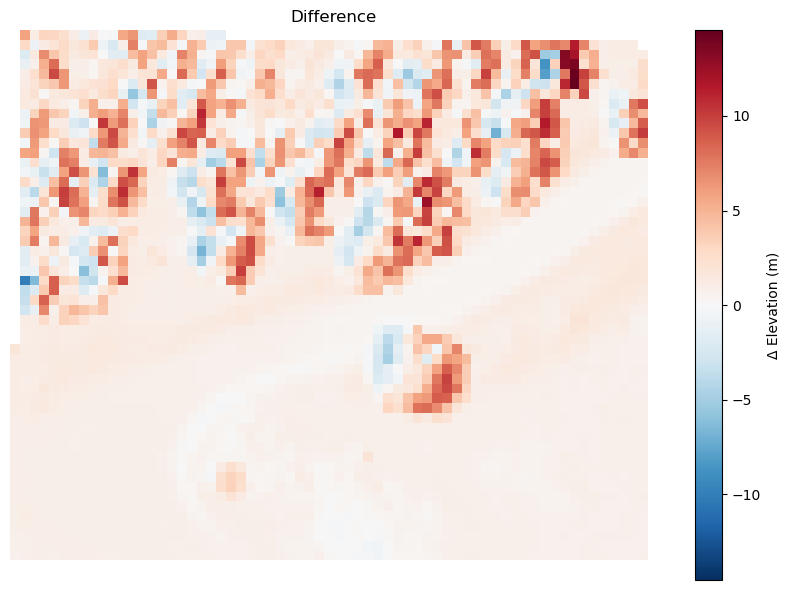

In [111]:
# Set units
dem1.set_units(vertical_unit="meter")
print("dem1 vertical_unit:", dem1.vertical_unit)

# Compute difference
pair = RasterPair(dem1, dem2)
result = pair.compute_difference(
    skip_epoch=True,
    interpolation_method="bilinear",
    clip_to_overlap=True,
    verbose=True
)

# Plot
fig = pair.plot_difference()

<h2><a id="download-laz"></a>Option 3: Download point clouds using OpenTopography API</h2>

This option allows you to define an area of interest (AOI), search the OpenTopography data catalog for available datasets, and download the point clouds to generate DEMs.

<h3><a id="api-key"></a>Finding and storing your API Key</h3>


We recommend storing your OT API key in a environment variable. This prevents keys from being hardcoded in the source code, reducing the risk of exposure through sharing or version control. It also enhances flexibility, allowing the same code to be used in various environments without changes. Below are the steps to take to store your API key in an environment variable.  

<h4><a id="Linux-macOS"></a>For Linux/macOS</h4>

Open up a Terminal window and find your shell's profile script. For Bash, you might find '~ /.bashrc' or '~ /.bash_profile'.
For Zsh, you might find '~ /.zshrc'.  

```cd ~```  
```ls -a```  

Once you know the name of your shell’s profile script, you can edit it using a text editor that operates in the terminal (like ```nano``` or ```vim```) or out side the terminal with the text editor of your choosing. This example will use '~/.zshrc' as the name of the shell profile script and ```nano``` as the text editor. If the file is read-only, you might need to use ```sudo``` to edit it.  

```nano ~/.zshrc```  

At the end of the .zshrc file, add a line to define your environment variable. 'your_api_key_here' is a stand in for the alphanumeric API key accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."   
 
```export OPENTOPOGRAPHY_API_KEY='your_api_key_here'```


Exit (```control + X``` for ```nano```) and save (```Y``` to ```Save modified buffer (ANSWERING "No" WILL DESTROY CHANGES) ?``` then ```Enter``` for ```nano```).

For your changes to take effect, you need to reload the .zshrc file or restart your terminal. To reload .zshrc without restarting, type the following command in your terminal and press Enter:  

```source ~/.zshrc```  

This will make the OPENTOPOGRAPHY_API_KEY environment variable available in all new terminal sessions.  

<h4><a id="Windows"></a>For Windows</h4> 

1. Search for "Environment Variables" in the Start menu.
1. Click on "Edit the system environment variables."
1. In the System Properties window, click on "Environment Variables."
1. Click on "New" under System variables or User variables depending on your need.
1. Set "Variable name" as OPENTOPOGRAPHY_API_KEY and "Variable value" as your actual API key. Your alphanumeric API key is accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."
1. Click OK and apply the changes.

<h3><a id="Load-API-Key"></a>Load API key</h3>

In [89]:
# After setting the environment variable, access your API key in this notebook.
API_Key = os.getenv("OPENTOPOGRAPHY_API_KEY")

# If your API key is not set, you can set it here.
#API_Key = "your_api_key_here"

if API_Key is not None:
    print("API Key loaded successfully!")
else:
    print("Failed to load API Key.")

API Key loaded successfully!


<h3><a id="Define-AOI"></a>Define area of interest</h3>

To specify the geographic region for your dataset search, you have three options. You can 1) manually enter latitude and longitude bounds if you know the exact coordinates of your area of interest; 2) upload a shapefile or GEOJSON to automatically populate the same extent variables; 3) draw a bounding box directly on the interactive map embedded in this notebook: simply click and drag to sketch the rectangle around your target area, and the notebook captures both the corner coordinates and the equivalent WKT polygon for your API queries.

<h4><a id="Option-1-Draw-Map"></a>Option 1: Draw a bounding box on an interactive map</h4>

In [90]:
da = DataAccess()
da.init_ot_catalog_map(zoom=3)

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [91]:
da.bounds

{'south': 39.629148,
 'west': -86.868151,
 'north': 39.656379,
 'east': -86.832453,
 'polygon_wkt': ['-86.868151, 39.629148, -86.868151, 39.656379, -86.832453, 39.656379, -86.832453, 39.629148, -86.868151, 39.629148']}

<h4><a id="Option-2-Manual-Bounds"></a> Option 2: Define bounds manually</h4>

In [43]:
da = DataAccess()
south = 38.953619
north = 38.953827
west =  -104.926257
east = -104.925967
da.define_bounds_manual(south, north, west, east)

{'south': 38.953619,
 'north': 38.953827,
 'west': -104.926257,
 'east': -104.925967,
 'polygon_wkt': ['-104.925967, 38.953619, -104.925967, 38.953827, -104.926257, 38.953827, -104.926257, 38.953619, -104.925967, 38.953619']}

<h4><a id="Option-3-Upload-File"></a> Option 3: Define bounds using an uploaded file</h4>

In [44]:
# # Define shapefile path for bounds
# # Update this path to match your shapefile location
# if IN_COLAB:
#     # In Colab, update this to your shapefile location in Google Drive
#     shapefile_path = get_data_path("bounds/bounds.shp")
# else:
#     # Local path - update as needed
#     shapefile_path = "/Users/cassandrabrigham/Documents/POSTDOC/Writing/Error_manuscript/Results/Data analysis/Topographic Datasets/Short scale/Point misclassification/Boulder/GIS/bounds.shp"

# da = DataAccess()
# da.define_bounds_from_file(shapefile_path, target_crs='EPSG:4326')

<h3><a id="Use-OT-Catalog-comp-ref"></a> Use OT Catalog To Find Paired Compare/Reference Datasets</h3>

This section uses OpenTopography’s `otCatalog` API endpoint to perform a bounding‐box search of available datasets within the area of interest defined above. 

In [92]:
# Initialize the OpenTopography query object with our DataAccess instance
otq = OpenTopographyQuery(da)

otq.query_catalog(
    product_format="PointCloud",    # only return point cloud products; use "Raster" or omit to get all
    include_federated=True,         # include external catalogs (e.g. USGS 3DEP) via OpenTopography
    detail=False,                   # set to True for full metadata; False returns summary fields
    save_as="results.json"          # save raw JSON response to this file for inspection or reuse
)

# Show the first few rows of the catalog dataframe
otq.catalog_df

Name    Short Name       ID type  \
0      2011 - 2013 Indiana Statewide Lidar  IN_2011_2013    opentopoID   
1  USGS LPC IN WT B11 Putnam 2013 LAS 2016          None  USGS_3DEP_ID   
2                IN Statewide Opt2 B3 2017          None  USGS_3DEP_ID   

  Data Source                              Property ID Horizontal EPSG  \
0          ot                      OTLAS.062012.4326.1            4326   
1        usgs  USGS_LPC_IN_WT_B11_Putnam_2013_LAS_2016            3857   
2        usgs                IN_Statewide_Opt2_B3_2017            3857   

              Vertical Coordinates                               Clean Name  \
0                           NAVD88        2011_2013_Indiana_Statewide_Lidar   
1          NAVD88 - Geoid09 (Feet)  USGS_LPC_IN_WT_B11_Putnam_2013_LAS_2016   
2  NAVD88 height - Geoid12B (ftUS)                IN_Statewide_Opt2_B3_2017   

    StartDate     EndDate  
0  2011-03-13  2012-04-30  
1  2013-02-14  2013-04-14  
2  2017-03-28  2019-06-30

<h4><a id="Select-Compare-Ref"></a> Select compare/reference datasets for differencing</h4>

In [93]:
# choose the indices of the desired reference and compare datasets 
compare_index   = 0   # Older/pre-event dataset
reference_index = 1   # Younger/post-event dataset

# now tell the query object which ones to use as which
otq.pick(compare_index, reference_index)

⚠️  Vertical CRSs differ between datasets
⚠️  Compare vertical CRS: 'NAVD88' - geoid not detected, use set_compare_geoid()
🔹 Reference Geoid: geoid09
🔹 Compare Units: metre
🔹 Reference Units: foot
⚠️  UNIT MISMATCH: Compare is meter, Reference is foot - conversion will be needed!
🔹 Compare Epoch: 2011-10-06 (2011.7616)
🔹 Reference Epoch: 2013-03-15 (2013.2000)


(Name                    2011 - 2013 Indiana Statewide Lidar
 Short Name                                     IN_2011_2013
 ID type                                          opentopoID
 Data Source                                              ot
 Property ID                             OTLAS.062012.4326.1
 Horizontal EPSG                                        4326
 Vertical Coordinates                                 NAVD88
 Clean Name                2011_2013_Indiana_Statewide_Lidar
 StartDate                                        2011-03-13
 EndDate                                          2012-04-30
 Name: 0, dtype: object,
 Name                    USGS LPC IN WT B11 Putnam 2013 LAS 2016
 Short Name                                                 None
 ID type                                            USGS_3DEP_ID
 Data Source                                                usgs
 Property ID             USGS_LPC_IN_WT_B11_Putnam_2013_LAS_2016
 Horizontal EPSG                        

In [94]:
compare_meta = otq.get_metadata_dict("compare")
compare_meta

{'epoch': 2011.7616438356165,
 'epoch_date': datetime.date(2011, 10, 6),
 'geoid_model': None,
 'is_orthometric': True,
 'horizontal_crs': '4326',
 'vertical_datum': 'NAVD88',
 'vertical_units': 'meter',
 'vertical_unit_info': UnitInfo('meter', factor=1.0),
 'vertical_crs_string': 'NAVD88',
 'name': '2011 - 2013 Indiana Statewide Lidar',
 'short_name': 'IN_2011_2013',
 'data_source': 'ot',
 'property_id': 'OTLAS.062012.4326.1'}

In [95]:
reference_meta = otq.get_metadata_dict("reference")
reference_meta

{'epoch': 2013.2,
 'epoch_date': datetime.date(2013, 3, 15),
 'geoid_model': 'geoid09',
 'is_orthometric': True,
 'horizontal_crs': '3857',
 'vertical_datum': 'NAVD88',
 'vertical_units': 'foot',
 'vertical_unit_info': UnitInfo('foot', factor=0.3048),
 'vertical_crs_string': 'NAVD88 - Geoid09 (Feet)',
 'name': 'USGS LPC IN WT B11 Putnam 2013 LAS 2016',
 'short_name': None,
 'data_source': 'usgs',
 'property_id': 'USGS_LPC_IN_WT_B11_Putnam_2013_LAS_2016'}

<h3><a id="Get-DEMs"></a> Download topographic data and interpolate Digital Elevation Models </h3>

In [96]:
# Initialize the DEM interpolation/download object with our DataAccess and OpenTopographyQuery instances
gdems = GetDEMs(da, otq)

# Folder where downloaded DEMs and intermediate files will be saved
# Update the subfolder path as needed for your data organization
folder = get_data_path("MN/ot_download")
os.makedirs(folder, exist_ok=True)

# Base name for output files (DEM files will be named like "output_name" + "_compare_DTM.tif", etc.)
output_name = "mn_differencing"

#gdems.set_compare_units('us_survey_foot')
#gdems.set_compare_units('foot')
gdems.set_compare_units('meter')
#gdems.set_reference_units('us_survey_foot')
gdems.set_reference_units('foot')
#gdems.set_reference_units('meter')

INFO:data_access:Set compare vertical units to: metre
INFO:data_access:Set reference vertical units to: foot


In [97]:
gdems.dem_download_workflow(
        folder,
        output_name,
        API_Key,                           
        dem_resolution = 1.0,           
        dataset_type = "compare",
        epoch = otq.compare_epoch,           
        filterNoise = True,             
        reclassify = False,         
        savePointCloud = True,         
        pc_resolution = 0.1,            
        outCRS = "WGS84 UTM",
        method="idw",                  
        nodata=-9999,                   
        max_dist=50,                   
        smooth_iter=0                   
    )           
    

gdems.dem_download_workflow(
        folder,
        output_name,
        API_Key,
        dem_resolution = 1.0,
        dataset_type = "reference",
        epoch = otq.reference_epoch,  
        filterNoise = True,
        reclassify = False,
        savePointCloud = True,
        pc_resolution = 0.1,            
        outCRS = "WGS84 UTM",   
        method="idw",                  
        nodata=-9999,                   
        max_dist=50,                   
        smooth_iter=0                   
    ) 

/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
INFO:data_access:Downloading OpenTopography dataset via S3: IN_2011_2013


✔️ Using epoch 2011-10-06 for compare dataset via PROJ string.


INFO:data_access:Found tile index candidate: IN_2011_2013/IN_2011_2013_TileIndex.zip
INFO:data_access:Found subdirectories: ['IN_2011_2013/East_IN/', 'IN_2011_2013/West_IN/']
INFO:data_access:Root level files: ['IN_2011_2013_TileIndex.zip']
INFO:data_access:Downloading tile index zip: IN_2011_2013/IN_2011_2013_TileIndex.zip
INFO:data_access:Reading shapefile: IN_2011_2013_TileIndex.shp
INFO:data_access:Tile index columns: ['Filename', 'MinX', 'MinY', 'MaxX', 'MaxY', 'URL', 'geometry']
INFO:data_access:Found 9 tiles intersecting with AOI (out of 44674 total)
INFO:data_access:First tile data: {'Filename': 'ot_in2013_30101595_12_1.las', 'MinX': np.float64(-86.88008149999999), 'MinY': np.float64(39.627263899999996), 'MaxX': np.float64(-86.86228899999998), 'MaxY': np.float64(39.64102159999999), 'URL': 'https://opentopography.s3.sdsc.edu/pc-bulk/IN_2011_2013/West_IN/IN_W_2013/Putnam/ot_in2013_30101595_12_1.las'}
INFO:data_access:URL column value: https://opentopography.s3.sdsc.edu/pc-bulk/IN

✔️ Using epoch 2013-03-15 for reference dataset via PROJ string.


In [98]:
pair = gdems.get_dtm_pair()
pair.print_summary()


RasterPair Summary

Raster 1: ot_downloadmn_differencing_compare_DTM.tif
  Epoch: 2011.7616438356165
  Geoid: None
  Orthometric: True
  Vertical Units: metre

Raster 2: ot_downloadmn_differencing_reference_DTM.tif
  Epoch: 2013.2
  Geoid: geoid09
  Orthometric: True
  Vertical Units: foot

Comparison:
  Horizontal CRS match: True
  Vertical CRS match:   True
  Geoid match:          False
  Epoch match:          False
  Units match:          False
  Grid match:           False

Transformations needed: vertical_datum, epoch, vertical_units, grid



In [99]:
result = pair.compute_difference(
    skip_epoch=True,          # Skip epoch transformation for speed
    
    interpolation_method="bilinear",
    clip_to_overlap=True,
    verbose=True
)


RasterPair: Computing Difference (raster2 - raster1)

RasterPair: Transform raster1 to match raster2
Transformations needed: ['vertical_datum', 'epoch', 'vertical_units', 'grid']

[Step 3] Vertical datum transformation
    orthometric → orthometric
    Geoid: None → geoid09
    ✓ Vertical datum transformation complete

[Step 3b] Vertical unit conversion
    meter → foot
    ✓ Unit conversion complete

[Step 4] Grid alignment to reference
/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
    ✓ Grid alignment complete

Transformation pipeline complete


Valid pixels:
    Raster1: 5,469,416 / 9,292,932 (58.9%)
    Raster2: 8,230,226 / 9,292,932 (88.6%)
    Both:    4,904,639 / 9,292,932

<h1><a id="visualization"></a>Visualization and Derived Rasters</h1>

This section focuses on visualizing the results and creating derived topographic products like hillshades and slope maps, which are useful for interpreting the observed changes[cite: 206].

<h2><a id="plot-dems"></a>Plot the DEMs and derive</h2>

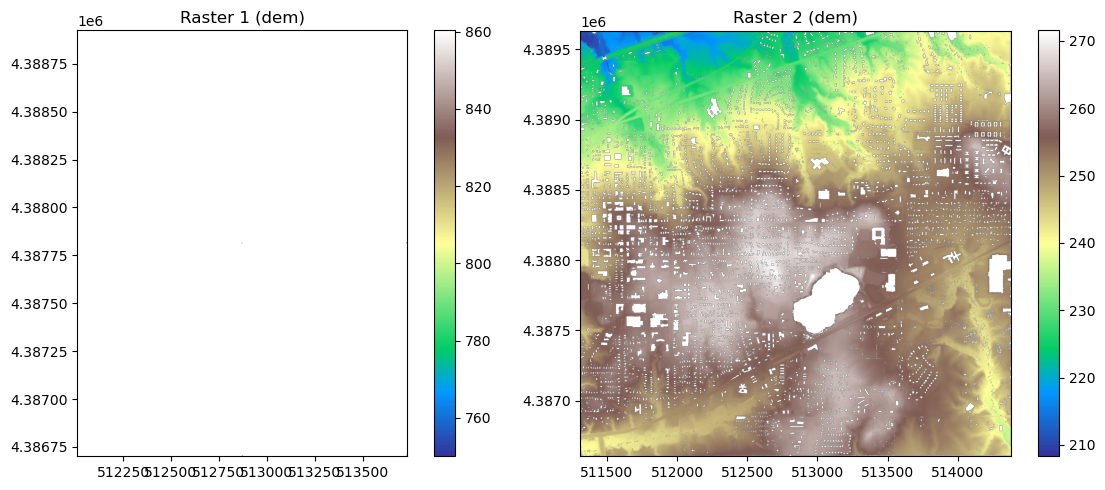

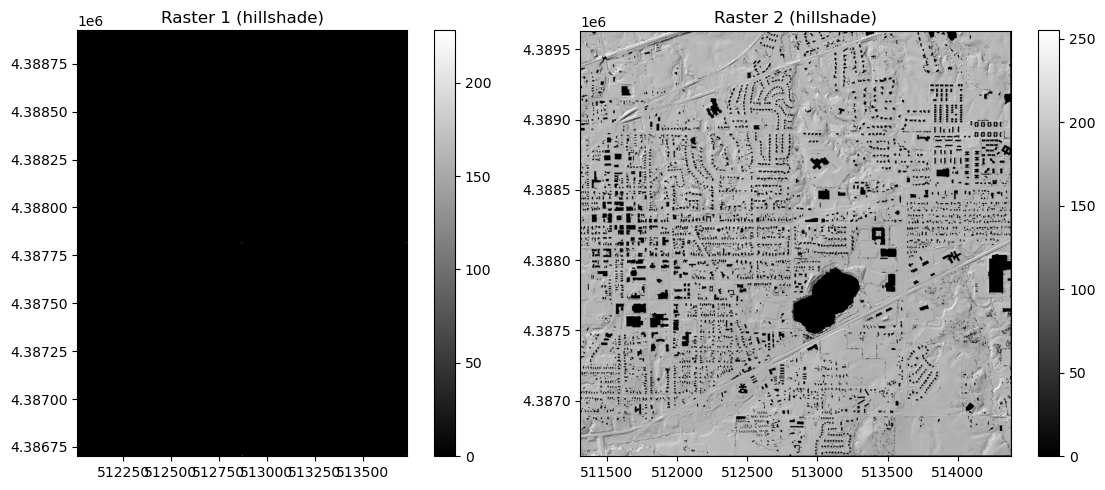

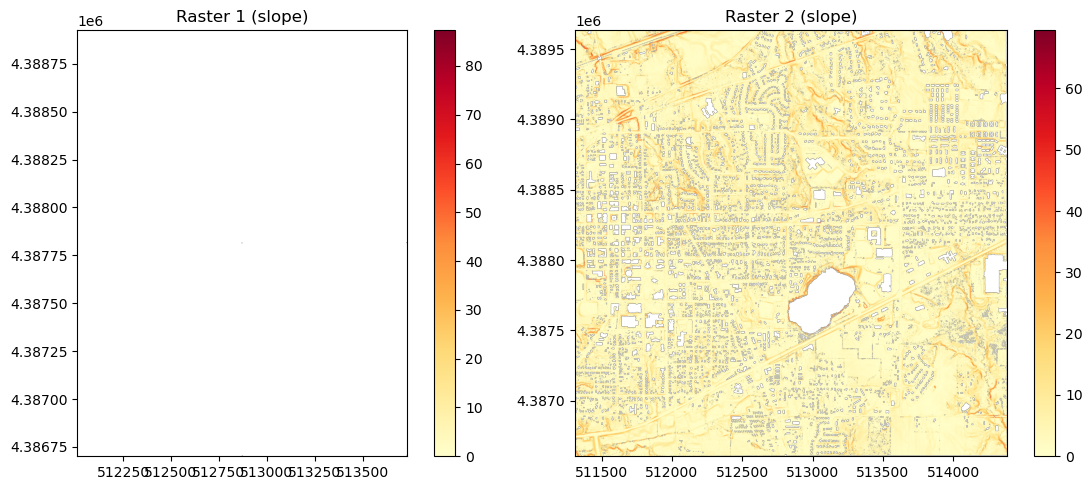

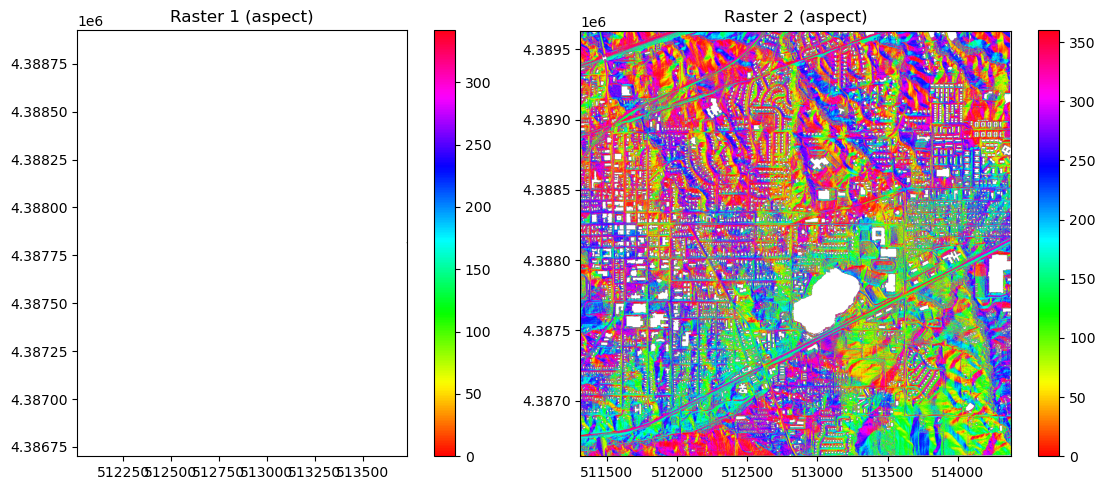

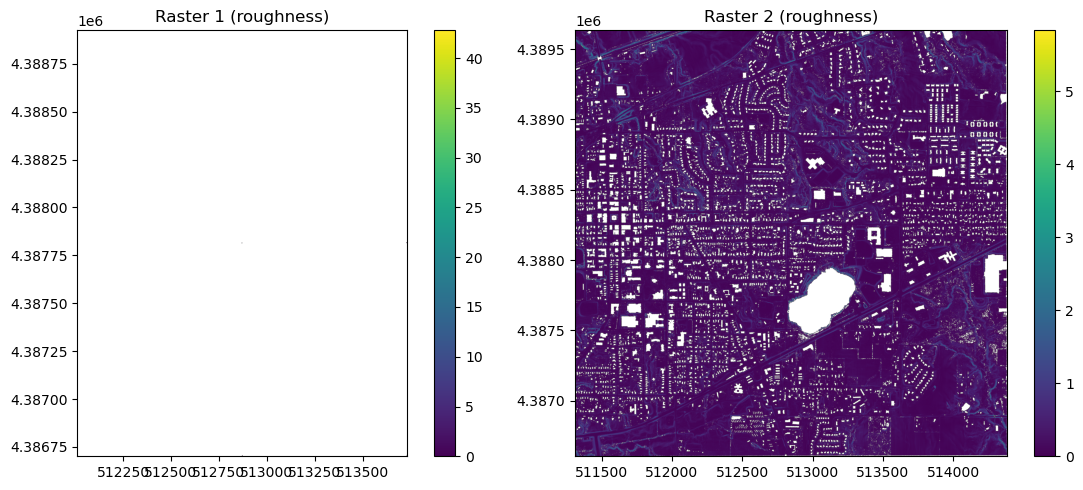

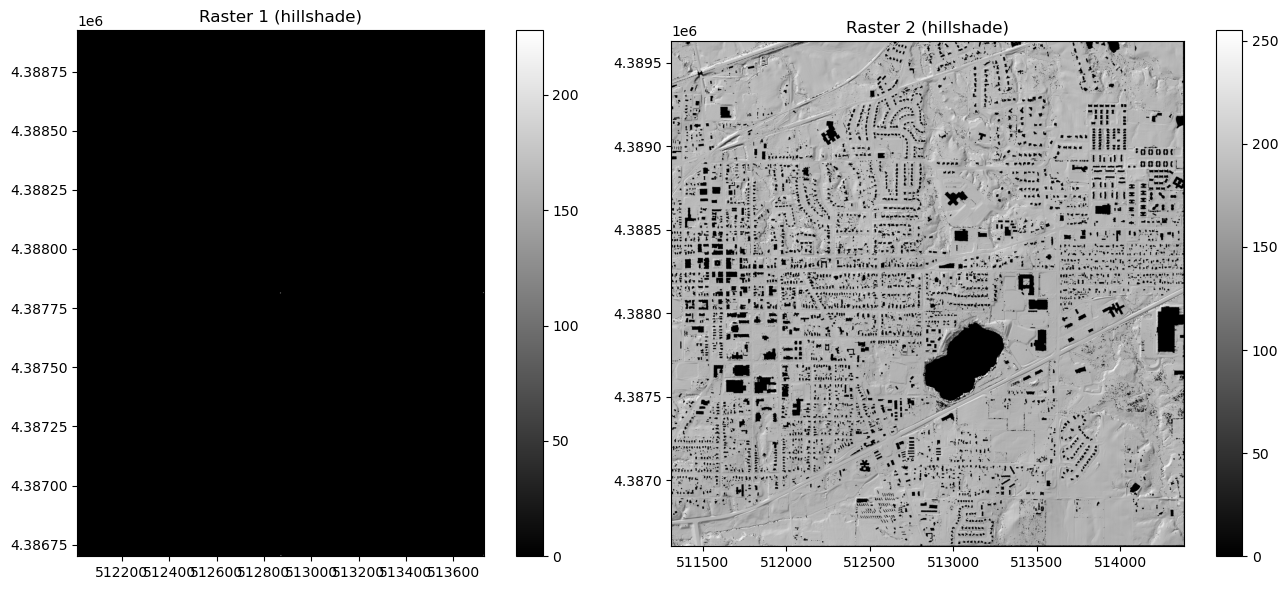

In [100]:
# Generate derivatives for both rasters
hillshade1, hillshade2 = pair.generate_derivative("hillshade")
slope1, slope2 = pair.generate_derivative("slope")
aspect1, aspect2 = pair.generate_derivative("aspect")
roughness1, roughness2 = pair.generate_derivative("roughness")

# Plot side-by-side with automatic derivative generation
fig, axes = pair.plot_pair(derivative='dem')        # Original DEMs
fig, axes = pair.plot_pair(derivative='hillshade')  # Hillshades
fig, axes = pair.plot_pair(derivative='slope')      # Slopes
fig, axes = pair.plot_pair(derivative='aspect')     # Aspects
fig, axes = pair.plot_pair(derivative='roughness')  # Roughness

# Customize hillshade parameters
fig, axes = pair.plot_pair(
    derivative='hillshade',
    azimuth=270,    # West-facing light
    altitude=30,    # Low sun angle
    figsize=(14, 6)
)

/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


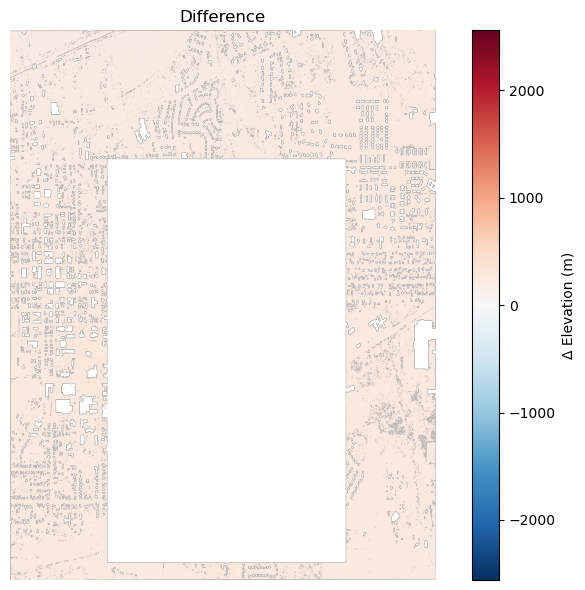

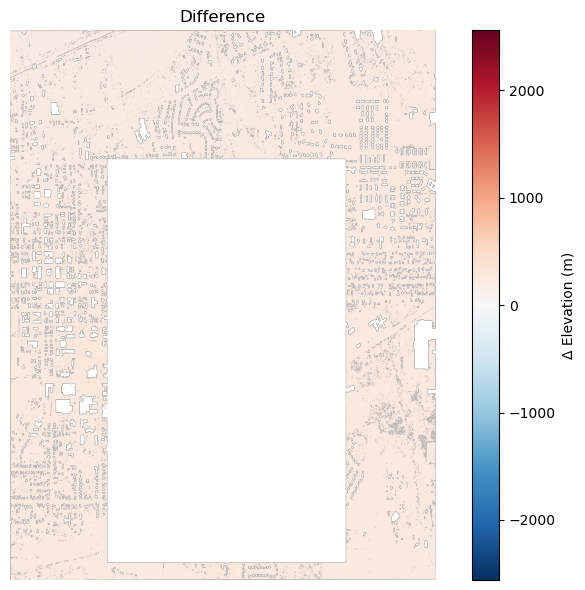

In [101]:
pair.plot_difference()

<h1><a id="error-analysis"></a>Error Analysis</h1>

<h2><a id="define-stable-areas"></a>Define stable areas</h2>

A key part of this workflow is the use of **stable areas**—regions where no topographic change is expected—to characterize the error between the two surveys. This interactive map allows you to manually draw polygons over areas you consider stable (e.g., roads, bedrock outcrops, undisturbed ground). [cite_start]The elevation differences within these areas are then used to model the uncertainty[cite: 220, 314, 315].

In [113]:
diff = result.get("difference_raster")

In [114]:
out_folder_poly = folder+"/polygons/"
os.makedirs(out_folder_poly, exist_ok=True)


interactor = TopoMapInteractor(
    topo_diff_path=diff.filename,
    hillshade_path=hillshade1.filename,
    output_dir=out_folder_poly,
    overlay_dpi=600,
    overlay_vmin=-2,
    overlay_vmax=2,
)

interactor.map

Overlay generation: raster shape=(56, 66), nodata=nan
Valid pixels: 3434 / 3696 (92.9%)
Color range: [-2.000, 2.000]
Data range: [-10.008, 14.522]
Saved overlay image: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data/MN/ot_download/polygons/reference_diff-ce1bfac7fe284cfe9c29b5e45fc81cd8.png
Generated data URL: 7450 characters (5570 bytes)
Map bounds (lat/lon): ((34.865538683748355, -119.21109388220506), (34.86605641906671, -119.2103858345863))
Map center: (34.86579755140753, -119.21073985839568)
Using overlay: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data/MN/ot_download/polygons/reference_diff-ce1bfac7fe284cfe9c29b5e45fc81cd8.png


/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Map(center=[34.86579755140753, -119.21073985839568], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [115]:
interactor.stable_geoms

[<POLYGON ((297895.263 3860409.462, 297893.384 3860390.637, 297927.529 386039...>]

In [116]:
interactor.unstable_geoms

[]

<h2><a id="descriptive-stats"></a>Descriptive Statistics</h2>

In [117]:
stable_polys, _ = interactor.export_geodataframes()

# one combined mask
rasterizer_stable = StableAreaRasterizer(interactor.topo_diff.path, stable_polys, nodata=-9999)
analyzer_stable = StableAreaAnalyzer(rasterizer_stable)

# Combined-area stats
df_all_stable_polys = analyzer_stable.stats_all(folder+"polygons/combined_stable.tif")

# Per-area stats
df_each_stable_poly = analyzer_stable.stats_each(folder+"polygons/each_stable/")


In [118]:
df_all_stable_polys

mean   median      mode       std   variance       min  \
all_areas  2.55418  1.61322  1.432739  3.558683  12.664226 -7.018921   

                 max  skewness  kurtosis  0.5_percentile  99.5_percentile  
all_areas  12.366333  0.289334 -0.260342       -5.954149        11.058461

In [119]:
df_each_stable_poly

mean   median      mode       std   variance       min        max  \
area_id                                                                         
0        2.55418  1.61322  1.432739  3.558683  12.664226 -7.018921  12.366333   

         skewness  kurtosis  0.5_percentile  99.5_percentile  
area_id                                                       
0        0.289334 -0.260342       -5.954149        11.058461

<h2><a id="estimate-error"></a>Estimate systematic error</h2>

In [130]:

# Load the stable area raster (this is the masked difference raster)
stable_area_path = folder + "polygons/combined_stable.tif"
stable_area = Raster.from_file(stable_area_path)

# Get the median from the stable area
# Read the data directly with rasterio to get valid values

with rasterio.open(stable_area_path) as src:
    data = src.read(1)
    nodata = src.nodata
    # Mask nodata values
    if nodata is not None:
        valid_data = data[data != nodata]
    else:
        valid_data = data[np.isfinite(data)]
    
    diff_stable_median = np.median(valid_data)
    print(f"Median of stable area differences: {diff_stable_median:.4f} m")

# Set up paths and parameters
output_path = folder + "polygons/combined_stable_bias_removed.tif"
unit = "m"
dem_resolution = 1.0

# Load raster data using RasterDataHandler
raster_data_handler = RasterDataHandler(stable_area_path, unit, dem_resolution)
raster_data_handler.load_raster()

# Get the data array
vert_diff_array = raster_data_handler.data_array

# Measure of vertical bias (median)
vertical_bias = np.median(vert_diff_array)
print(f"Vertical bias: {vertical_bias:.4f} m")

# Get uncertainty in the median value by bootstrap resampling
stats = StatisticalAnalysis(raster_data_handler)
median_uncertainty = stats.bootstrap_uncertainty_subsample(n_bootstrap=1000, subsample_proportion=0.1)
print(f"Median uncertainty (bootstrap): {median_uncertainty:.4f} m")

# Subtract the vertical bias from the stable area raster and save
raster_data_handler.subtract_value_from_raster(output_path, vertical_bias)
print(f"Saved bias-removed raster to: {output_path}")

# Create new RasterDataHandler for the modified raster
raster_bias_removed = RasterDataHandler(output_path, unit, dem_resolution)
raster_bias_removed.load_raster()

print(f"\nBias-removed stats:")
print(f"  Mean: {np.mean(raster_bias_removed.data_array):.4f} m")
print(f"  Median: {np.median(raster_bias_removed.data_array):.4f} m")
print(f"  Std: {np.std(raster_bias_removed.data_array):.4f} m")

Median of stable area differences: 1.6132 m
Vertical bias: 1.6132 m
Median uncertainty (bootstrap): 0.5951 m
Saved bias-removed raster to: /Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/new_try/data/MN/ot_downloadpolygons/combined_stable_bias_removed.tif

Bias-removed stats:
  Mean: 0.9410 m
  Median: 0.0000 m
  Std: 3.5587 m


/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


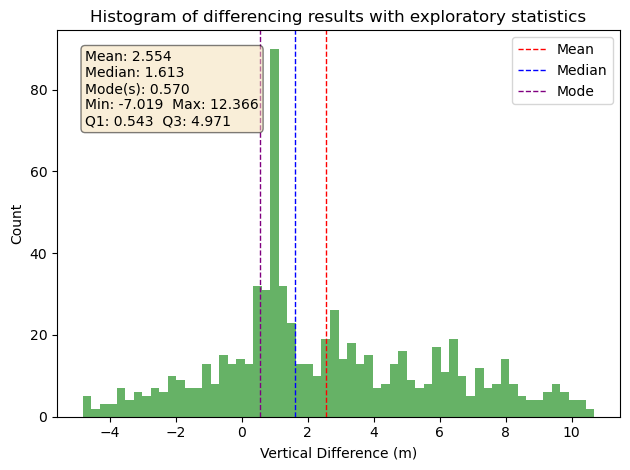

In [121]:
fig = stats.plot_data_stats()

<h2><a id="Variography"></a>Variography</h2>

This section uses the stable areas defined above to perform the geostatistical analysis. An experimental variogram is calculated from the DoD values within the stable areas, and then a mathematical model (nested spherical) is fitted to it. This model captures the spatial correlation of the error, which is then used to propagate uncertainty across the entire study area[cite: 113, 127].

In [122]:
#Create variogram analysis instance based on modified raster
V = VariogramAnalysis(raster_bias_removed)

#Calculate a mean variogram with 75 bins from variograms made over 10 runs
V.calculate_mean_variogram_numba(area_side = 2, samples_per_area = 4, max_samples = 1000000000, bin_width = 30, max_n_bins = 3000, n_runs = 30, max_lag_multiplier = 0.5)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/topographic-differencing-uncertainty/variogram.py:534: RuntimeWarning: Mean of empty slice
  mean_variogram = np.nanmean(vario_arr, axis=0)
/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/topographic-differencing-uncertainty/variogram.py:538: RuntimeWarning: Mean of empty slice
  mean_count = np.nanmean(count_arr, axis=0)
/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [123]:
BOUNDS = None

V.fit_best_spherical_model(sigma_type='std', bounds=BOUNDS, seed=SEED)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/topographic-differencing-uncertainty/variogram.py:652: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_synth, _ = curve_fit(
/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/crs_transformation/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


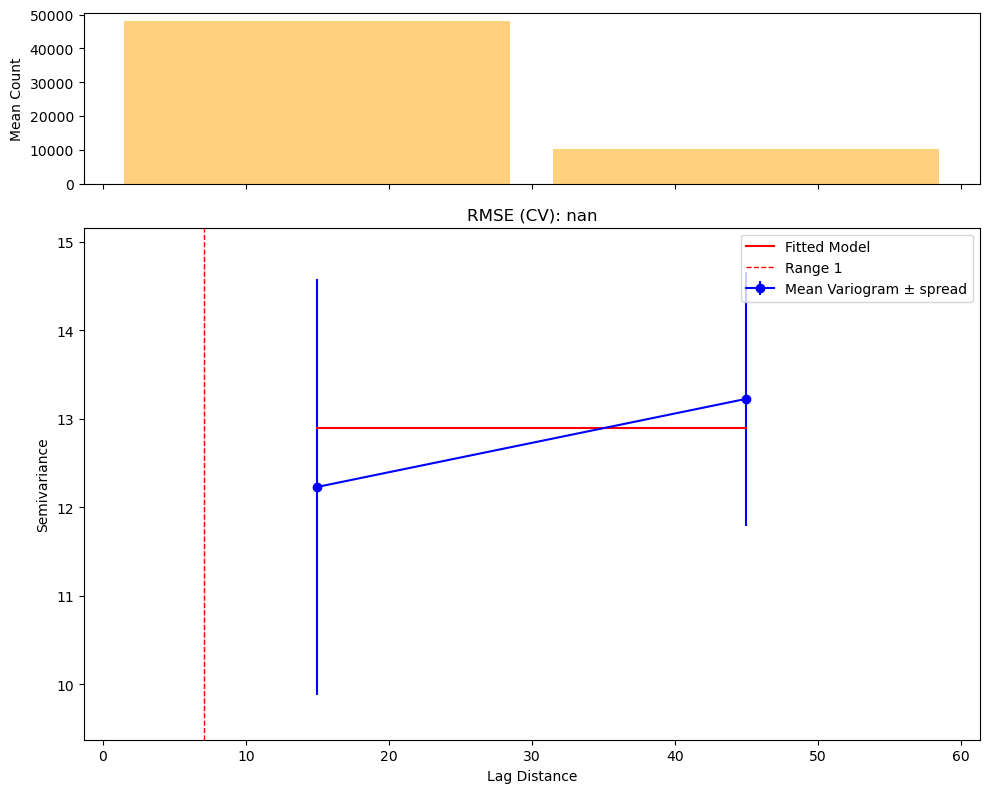

In [124]:
fig = V.plot_best_spherical_model()

<h2><a id="Total mean error"></a>Total mean error</h2>

In [125]:
interactor.map

Map(bottom=53224784.0, center=[34.86579228450567, -119.21075820922853], controls=(ZoomControl(options=['positi…

In [126]:
interactor.unstable_geoms

[<POLYGON ((297924.566 3860381.959, 297924.297 3860369.757, 297941.956 386037...>]

In [128]:
_, unstable_polys = interactor.export_geodataframes()

In [131]:
uncertainties_per_feature_of_interest = []
for i, poly in enumerate(unstable_polys['geometry']):
    uncertainty_temp = RegionalUncertaintyEstimator(raster_bias_removed, V, area_of_interest=poly)
    uncertainty_temp.calc_mean_uncertainty(n_pairs=25_000, seed=SEED, sigma_func=None)
    uncertainties_per_feature_of_interest.append(uncertainty_temp)

total_mean_uncertainty_raster = uncertainties_per_feature_of_interest[0].total_mean_uncertainty_raster
total_mean_uncertainty_min_raster = uncertainties_per_feature_of_interest[0].total_mean_uncertainty_min_raster
total_mean_uncertainty_max_raster = uncertainties_per_feature_of_interest[0].total_mean_uncertainty_max_raster

mean_random_uncorrelated_raster = uncertainties_per_feature_of_interest[0].mean_random_uncorrelated_raster

total_mean_correlated_uncertainties_polygon = []
total_mean_correlated_uncertainties_polygon_min = []
total_mean_correlated_uncertainties_polygon_max = []

total_mean_uncorrelated_uncertainties_polygon = []

total_mean_uncertainties_polygon = []
total_mean_uncertainty_min_polygon = []
total_mean_uncertainty_max_polygon = []

for uncertainty in uncertainties_per_feature_of_interest:
    mean_correlated_uncertainty_polygon = uncertainty.total_mean_correlated_uncertainty_polygon
    mean_correlated_uncertainty_min_polygon = uncertainty.total_mean_correlated_uncertainty_min_polygon
    mean_correlated_uncertainty_max_polygon = uncertainty.total_mean_correlated_uncertainty_max_polygon
    
    mean_uncertainty_polygon = uncertainty.total_mean_uncertainty_polygon
    mean_uncertainty_min_polygon = uncertainty.total_mean_uncertainty_min_polygon
    mean_uncertainty_max_polygon = uncertainty.total_mean_uncertainty_max_polygon
    
    mean_random_uncorrelated = uncertainty.mean_random_uncorrelated
    
    total_mean_correlated_uncertainties_polygon.append(mean_correlated_uncertainty_polygon)
    total_mean_correlated_uncertainties_polygon_min.append(mean_correlated_uncertainty_min_polygon)
    total_mean_correlated_uncertainties_polygon_max.append(mean_correlated_uncertainty_max_polygon)
    
    total_mean_uncorrelated_uncertainties_polygon.append(mean_random_uncorrelated)
    
    total_mean_uncertainties_polygon.append(mean_uncertainty_polygon)
    total_mean_uncertainties_polygon.append(mean_uncertainty_min_polygon)
    total_mean_uncertainties_polygon.append(mean_uncertainty_max_polygon)


    

AttributeError: 'RegionalUncertaintyEstimator' object has no attribute 'mean_random_uncorrelated_raster'